<a href="https://colab.research.google.com/github/alishachandni/Anomaly-Detection/blob/main/brain_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import shutil

In [ ]:
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/Final Project/Brain MRI"

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 150
LATENT_DIM = 128

def load_and_preprocess_images(dataset_path):
    images, labels = [], []
    for label in ["yes", "no"]:
        class_path = os.path.join(dataset_path, label)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=IMG_SIZE)
            img = img_to_array(img) / 255.0
            images.append(img)
            labels.append(0 if label == "no" else 1)  # 0 = Normal, 1 = Tumor
    return np.array(images), np.array(labels)

X, y = load_and_preprocess_images(dataset_path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

LATENT_DIM = 128

# Encoder
def build_encoder():
    inputs = layers.Input(shape=(128, 128, 3))  # Input shape (image size)
    x = layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)

    z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
    z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)

    # Sampling function
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

    return models.Model(inputs, [z_mean, z_log_var, z], name="Encoder")

# Decoder
def build_decoder():
    inputs = layers.Input(shape=(LATENT_DIM,))
    x = layers.Dense(32 * 32 * 128, activation='relu')(inputs)
    x = layers.Reshape((32, 32, 128))(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=1, padding='same', activation='sigmoid')(x)

    return models.Model(inputs, x, name="Decoder")

# Custom VAE Loss Layer
class VAELossLayer(layers.Layer):
    def call(self, inputs):
        x, x_decoded, z_mean, z_log_var = inputs

        recon_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, x_decoded))

        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

        self.add_loss(recon_loss + kl_loss)
        return x_decoded

# Compile VAE
def compile_vae(encoder, decoder):
    inputs = layers.Input(shape=(128, 128, 3))
    z_mean, z_log_var, z = encoder(inputs)
    recon_images = decoder(z)

    # Add custom loss layer
    outputs = VAELossLayer()([inputs, recon_images, z_mean, z_log_var])

    vae = models.Model(inputs, outputs, name="VAE")
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002))

    return vae


In [ ]:
adversarial_losses = []
contextual_losses = []
encoder_losses = []
total_losses = []

class LossTracker(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        """Callback function to store losses at the end of each epoch."""
        logs = logs or {}

        # Extract loss values
        adversarial_loss = logs.get('loss', 0)  # VAE loss
        contextual_loss = logs.get('val_loss', 0)  # Validation loss
        encoder_loss = logs.get('kl_loss', 0)
        total_loss = adversarial_loss + contextual_loss  # Total loss

        # Store values in lists
        adversarial_losses.append(adversarial_loss)
        contextual_losses.append(contextual_loss)
        encoder_losses.append(encoder_loss)
        total_losses.append(total_loss)

        # Print loss values
        print(f"Epoch {epoch+1}: Adversarial Loss: {adversarial_loss:.4f}, "
              f"Contextual Loss: {contextual_loss:.4f}, "
              f"Encoder Loss: {encoder_loss:.4f}, "
              f"Total Loss: {total_loss:.4f}")

# Training and tracking losses
encoder = build_encoder()
decoder = build_decoder()
vae = compile_vae(encoder, decoder)

vae.fit(
    X_train, X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, X_test),
    callbacks=[LossTracker()]  # Attach the custom callback
)


Epoch 1/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.7100Epoch 1: Adversarial Loss: 0.7101, Contextual Loss: 0.6911, Encoder Loss: 0.0000, Total Loss: 1.4013
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 599ms/step - loss: 0.7101 - val_loss: 0.6911
Epoch 2/150
5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6915Epoch 2: Adversarial Loss: 0.6914, Contextual Loss: 0.6835, Encoder Loss: 0.0000, Total Loss: 1.3749
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6915 - val_loss: 0.6835
Epoch 3/150
5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6809Epoch 3: Adversarial Loss: 0.6783, Contextual Loss: 0.6689, Encoder Loss: 0.0000, Total Loss: 1.3472
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6800 - val_loss: 0.6689
Epoch 4/150
5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6662Epoch 4: Adversarial Loss: 0.6600, Contextual Loss: 0.6438, Encoder Loss: 0.0000, Total Loss: 1.3038
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6640 - val_loss: 0.6438
Epoch 5/150
5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 

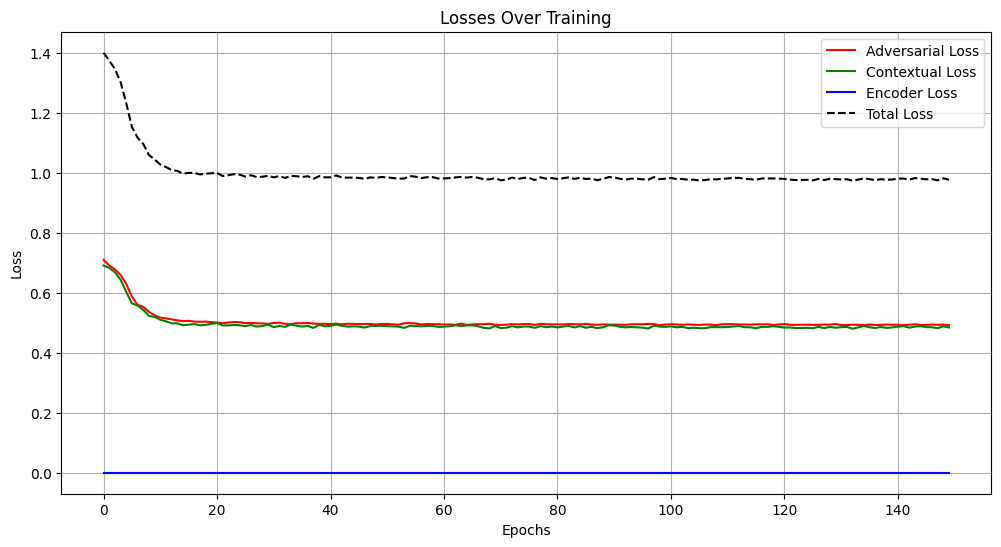

In [ ]:
plot_losses(adversarial_losses, contextual_losses, encoder_losses, total_losses)


In [ ]:
# LSTM-GAN Model
def build_lstm_gan():
    model = models.Sequential([
        layers.LSTM(128, return_sequences=True, input_shape=(IMG_SIZE[0], IMG_SIZE[1])),
        layers.LSTM(64, return_sequences=False),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Compute Reconstruction Error as Anomaly Score
X_train_recon = vae.predict(X_train)
X_test_recon = vae.predict(X_test)
train_errors = np.mean(np.abs(X_train - X_train_recon), axis=(1, 2, 3))
test_errors = np.mean(np.abs(X_test - X_test_recon), axis=(1, 2, 3))

# Train LSTM-GAN using Reconstruction Errors
lstm_gan = build_lstm_gan()
lstm_gan.fit(train_errors.reshape(-1, 1, 1), y_train, epochs=50, batch_size=16)

# Predict Anomalies
y_pred = lstm_gan.predict(test_errors.reshape(-1, 1, 1))

# Evaluate Model
auc = roc_auc_score(y_test, y_pred)
print(f"AUC Score: {auc:.3f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6344 - loss: 0.6919
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5758 - loss: 0.6913
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6120 - loss: 0.6894
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6410 - loss: 0.6870
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6308 - loss: 0.6858
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6327 - loss: 0.6841
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6558 - loss: 0.6806
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6022 - loss: 0.6839
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6701 - loss: 0.6752
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6375 - loss: 0.6769
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6753 - loss: 0.6695
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5865 - loss: 0.6817


AUC Score: 0.662


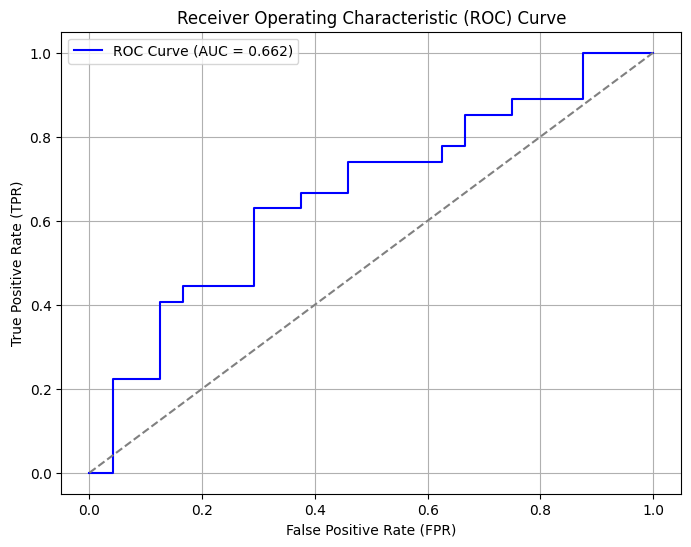

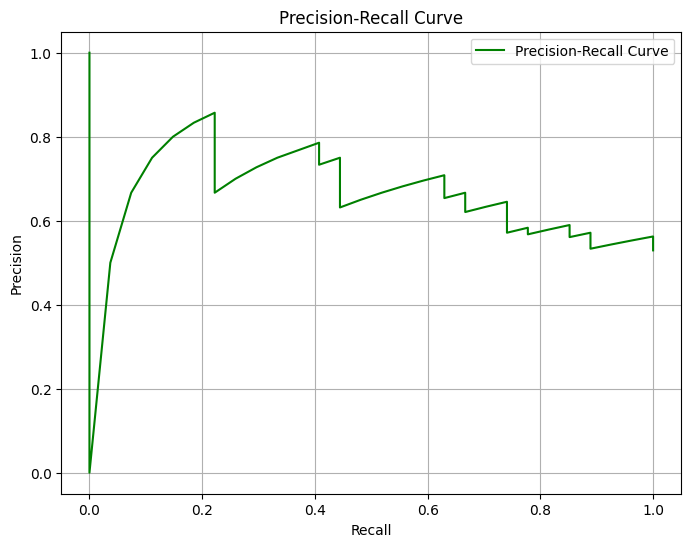

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

#  Function to Plot ROC Curve
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc_value = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_value:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to Plot Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

#  Compute AUC Score
auc_score = roc_auc_score(y_test, y_pred)
print(f"AUC Score: {auc_score:.3f}")

plot_roc_curve(y_test, y_pred)

plot_precision_recall_curve(y_test, y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


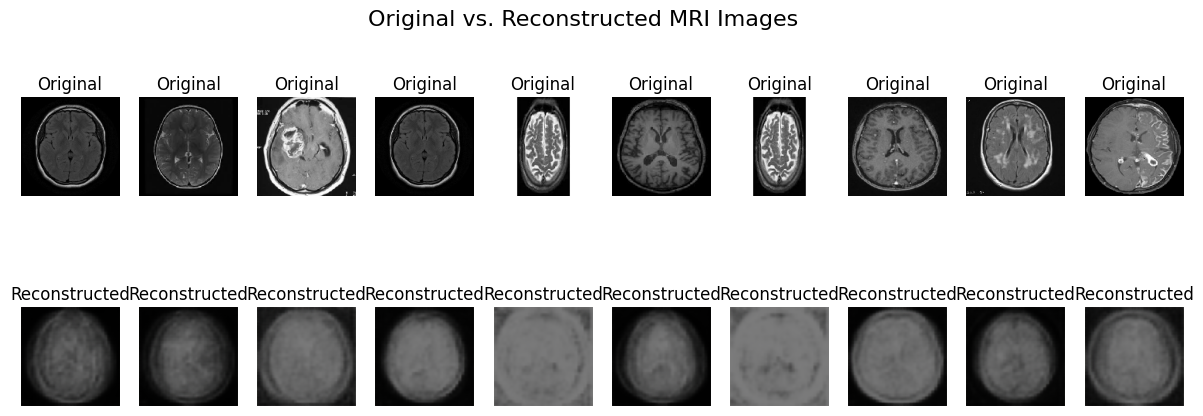

In [ ]:
import matplotlib.pyplot as plt

def show_reconstructed_images(vae, X_test, num_images=10):

    random_indices = np.random.choice(len(X_test), num_images)
    original_images = X_test[random_indices]

    reconstructed_images = vae.predict(original_images)

    # Plot images
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))

    for i in range(num_images):
        # Display original image
        axes[0, i].imshow(original_images[i])
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        # Display reconstructed image
        axes[1, i].imshow(reconstructed_images[i])
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")

    plt.suptitle("Original vs. Reconstructed MRI Images", fontsize=16)
    plt.show()

# Call the function to display images
show_reconstructed_images(vae, X_test, num_images=10)
